In [1]:
import torch
from torchaudio.datasets import SPEECHCOMMANDS
import os
import torchaudio
from os.path import join
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from math import log2
import numpy as np

## Load Data (Google Speech Commands V2)

In [2]:
# modified version of 
#.  https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(map(os.path.abspath, excludes))
            self._walker = [w for w in self._walker if os.path.abspath(w) not in excludes]
    
    def __getitem__(self, idx):
      fname = self._walker[idx]
      x = torchaudio.load(fname)[0]
      split = fname.split("/")
      word = split[-2]
      id = split[-1].rstrip(".wav")
      return (x, word, id)

In [3]:
train = SubsetSC("training")
val = SubsetSC("validation")
test = SubsetSC("testing")
print(len(train), len(val), len(test))

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

84843 9981 11005


In [4]:
train[0]

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
 'backward',
 '0165e0e8_nohash_0')

### Process Data

In [5]:
fmin = 100
fmax = 6000
bins = 50
hop_length = 64
bins_per_octave = int(bins / log2(fmax/fmin) + 0.5)
print(f"Creating constant-q filter with {bins_per_octave} bins per octave")
transform = lambda x: librosa.cqt(x, sr=16000, hop_length=hop_length, fmin=fmin, n_bins=bins, bins_per_octave=bins_per_octave)

Creating constant-q filter with 8 bins per octave


In [26]:
def save_data(data, dir):
  x, word, id = data
  X = torch.tensor(transform(x.numpy()[0]))
  item = (X, word)
  word_dir = join(dir, word)
  os.makedirs(word_dir, exist_ok=True)
  f = open(join(word_dir, id + ".pt"), "wb")
  torch.save(item, f)

In [27]:
idx = 9000
x = train[idx][0][0].numpy()
Audio(x, rate=16000)

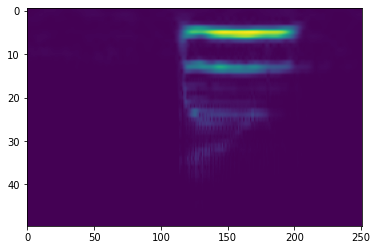

In [28]:
transformed = np.abs(transform(x))
plt.imshow(transformed, aspect="auto")

In [29]:
# TODO: this part is currently too slow
for x in train:
  save_data(x, "processed/train")

for x in val:
  save_data(x, "processed/val")

for x in test:
  save_data(x, "processed/test")

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=128 is too small for input signal of length=107
  n_fft, y.shape[-1]
